In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Goals:
1. Set up directories for training, validation, testing (optional)
2. Mapping out process -> use Keras ImageDataGenerator to onrmalize and batch image samples for model consumption

In [ ]:
base_dir = '/content/drive/MyDrive/CAPSTONE 2024 2025/COE70B - Sem 2/Phase 1/Prayash/Emotions'
train_dir = os.path.join(base_dir, 'train')

val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


#Data preprocessing
#Normalizing data between 0 to 1
train_datagen = ImageDataGenerator(rescale=1./255) #0 to 1
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle = True,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)


Found 343 images belonging to 8 classes.
Found 42 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


Computer Vision

Goals:
Apply different comp vis. techniques

1) grayscale

2) ORB feature extraction -> algorithm that picks out key points in image and creates descriptors for each keypoint... helpful for finding data signatures within keypoints to compare and match similarities with different images
3) gauss. blur

4) edge detection

5) corner detection

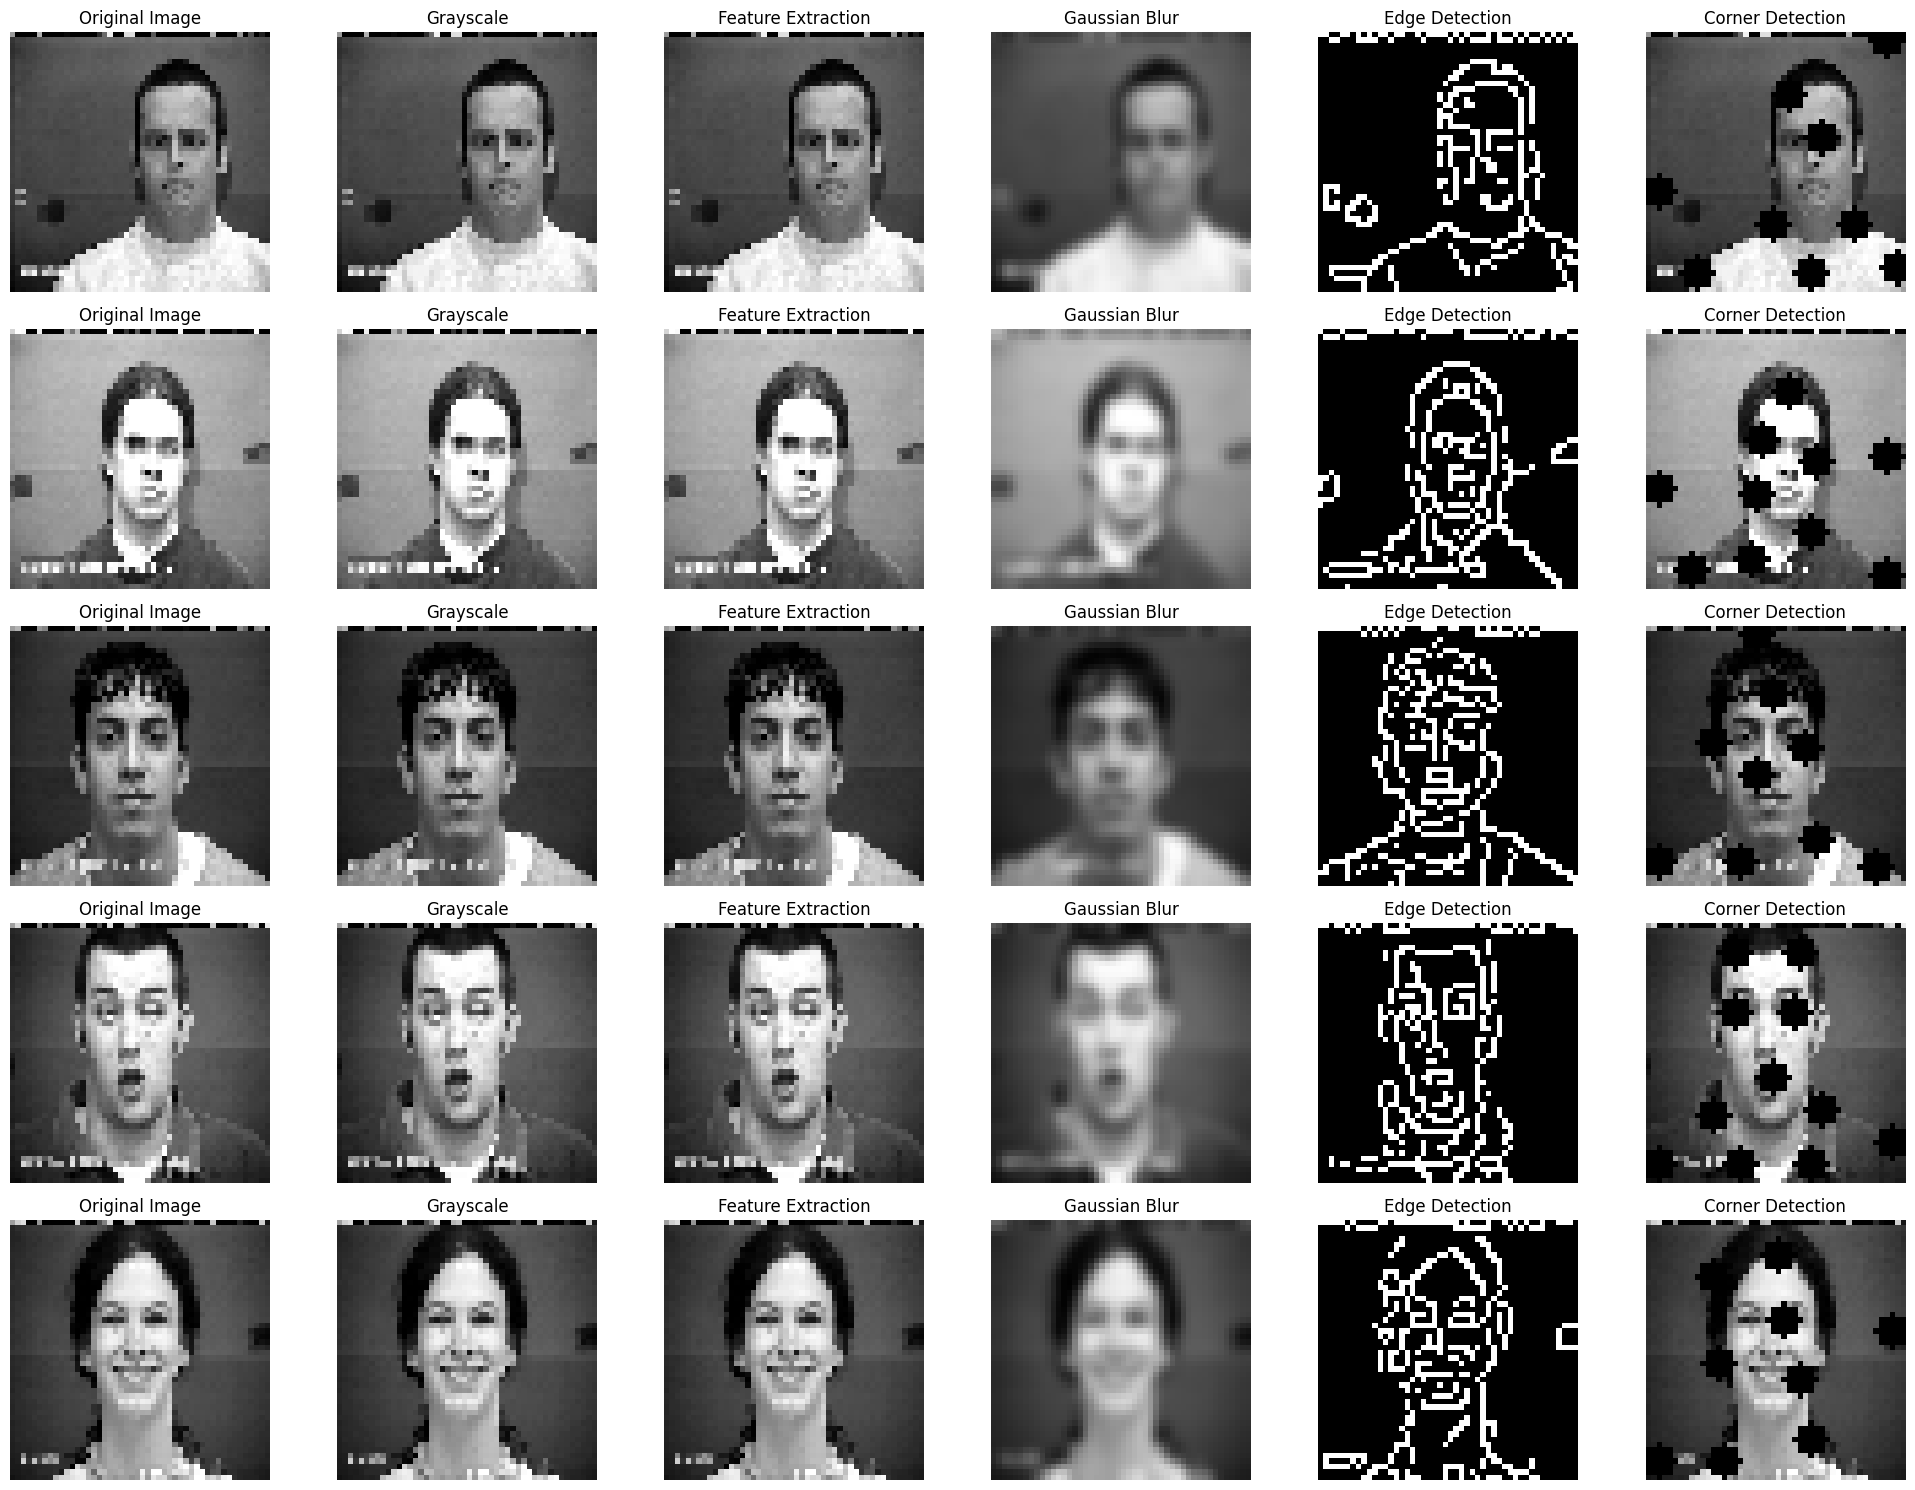

In [ ]:
#def rgb_to_gray(image):
    #return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #return (gray*255).astype(np.uint8)

def rgb_to_gray(image):
    gray_float = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # This might still be float
    gray_uint8 = (gray_float * 255).astype('uint8')
    return gray_uint8

#uses the ORB (Oriented FAST and Rotated BRIEF) aglorithm to detect key points and compute descriptors
def feature_extraction(image):
  image_unit8 = (image*255).astype(np.uint8)
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(image_unit8, None)
  return cv2.drawKeypoints(image_unit8, keypoints, None, color=(0, 255, 0), flags=0)

#reduce noise
def gaussian_filter(image):
  return cv2.GaussianBlur(image, (5, 5), 0)

#detects edges in the grayscale image using the canny edge detection algorithm
#def edge_detection(image):
  #return cv2.Canny(image, 100, 200)

def edge_detection(image):
    # If 'image' is a float64 or float32 (range [0,1]), convert it to 8-bit:
    image_8u = (image * 255).astype('uint8')
    return cv2.Canny(image_8u, 100, 200)

#finds and marks corners in the image
def corner_detection(image):
  corners = cv2.goodFeaturesToTrack(image, maxCorners=25, qualityLevel=0.01, minDistance=10)
  if corners is not None:
    for corner in corners:
      x, y = corner.ravel()
      cv2.circle(image, (int(x), int(y)), 3, (0, 0, 255), -1)
  return image



def apply_computer_vision_techniques(images):
  processed_images = []
  for img in images:
    gray = rgb_to_gray(img)
    features = feature_extraction(img)
    blurred = gaussian_filter(img)
    edges = edge_detection(gray)
    corners = corner_detection(gray.copy())
    processed_images.append((img, gray, features, blurred, edges, corners))
  return processed_images

# Load a few sample images
sample_images, sample_labels = [], []
for i in range(5):
    img, label = next(train_generator)
    sample_images.append(img[0])
    sample_labels.append(label[0])

#Apply techniques on sample images
processed_images = apply_computer_vision_techniques(sample_images)

def display_processed_images(processed_images):
  plt.figure(figsize=(20, 15))

  for i, (original, gray, features, blurred, edges, corners) in enumerate(processed_images):
    plt.subplot(5, 6, i * 6 + 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 6, i * 6 + 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(5, 6, i * 6 + 3)
    plt.imshow(features)
    plt.title('Feature Extraction')
    plt.axis('off')

    plt.subplot(5, 6, i * 6 + 4)
    plt.imshow(blurred)
    plt.title('Gaussian Blur')
    plt.axis('off')

    plt.subplot(5, 6, i * 6 + 5)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    plt.subplot(5, 6, i * 6 + 6)
    plt.imshow(corners, cmap='gray')
    plt.title('Corner Detection')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

display_processed_images(processed_images)


Goal:

1. Use VGG16 pretrained weights and apply transfer learning

2. Remove fully connected top layer with own layer which creates a classifier based on the len() of number of emotion categories (we have 8)

Flatten: multi dimensional output from CNN flattened to 1d vector which can be fed to fully connected top layer

First dense layer: leanrs to features 128 neurons (ie. each of these 128 neurons captures a different aspect/pattern in the data that might be useful for distinguishing one emotion from another)

Dropout: Random dropping of some neurons during training to prevent overfitting, making sure no single neuron gets "too attached" to any single sample feature

Second dense layer: final output layer using softmax activation function to turn leanred features int probalities for each category

In [ ]:
#Transfer learning

def create_transfer_learning_model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
  #freeze middle layers (tranfer learning part)
  for layer in base_model.layers:
    layer.trainable = False

  #add custom layers
  x = base_model.output
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)

  #our own top level classifier (# of classfication outputs equal to the number of emotion categories, ie. 8)
  predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

transfer_learning_model = create_transfer_learning_model()
transfer_learning_history = transfer_learning_model.fit(train_generator, epochs=40, validation_data=val_generator)




Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1461 - loss: 2.5018 - val_accuracy: 0.1190 - val_loss: 2.1669
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2385 - loss: 2.0764 - val_accuracy: 0.1905 - val_loss: 2.1224
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.1936 - loss: 2.0981 - val_accuracy: 0.1190 - val_loss: 2.1051
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2407 - loss: 1.9333 - val_accuracy: 0.1190 - val_loss: 2.0840
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3218 - loss: 1.8387 - val_accuracy: 0.1667 - val_loss: 2.0910
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3339 - loss: 1.8154 - val_accuracy: 0.1190 - val_loss: 2.0665
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2922 - loss: 1.8173 - val_accuracy: 0.1667 - val_loss: 2.0450
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3100 - loss: 1.7786 - val_accuracy: 0.1667 - val_loss: 2.0464
Epo

In [ ]:
#Retrieve and display training and validation accuracy
#Shows model preformance

train_accuracy = transfer_learning_history.history['accuracy']
val_accuracy = transfer_learning_history.history['val_accuracy']

print(f"Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")

#Evaluate transfer learning model on the validation (intermediary test) set
transfer_learning_scores = transfer_learning_model.evaluate(val_generator)
print(f"Test Loss: {transfer_learning_scores[0]:.4f}, Test Accuracy: {transfer_learning_scores[1] * 100:.2f}%")



Training Accuracy: 55.69%
Validation Accuracy: 23.81%
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.2316 - loss: 2.0989
Test Loss: 2.0555, Test Accuracy: 23.81%


Picks random images from validation data and runs them through transfer learning model. It selects only images where the model's prediction matches the true label and makes sure each prediction comes from a different class.

Display matching images along with true and predicted emotion labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

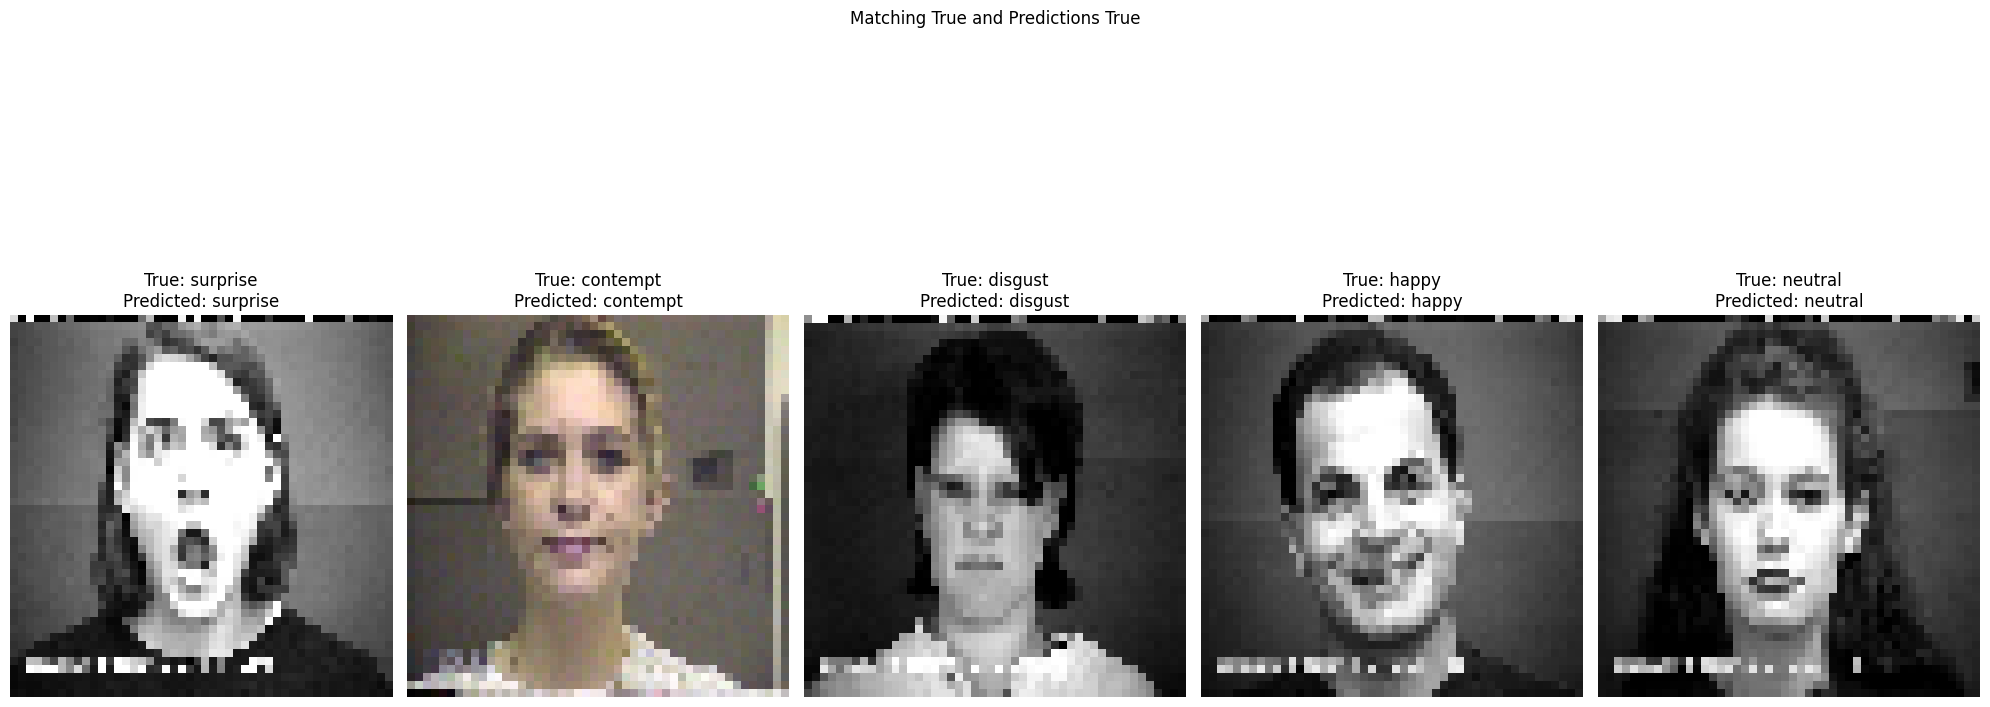

In [ ]:
#Different categorical classes

import numpy as np
import matplotlib.pyplot as plt

#Function to predict random images ensuring different predicted classes
def predict_random_images(generator, model, n=5):
  matching_images = [] #for storing images where prediction matches true label
  matching_predicted_classes = [] #for storing predicted classes for matching images
  matching_true_classes = [] #for storing true classes for matching imges

  selected_classes = set() #to keep track of selected classes

  while len(matching_images) < n:
    img, label = next(generator) #get a batch of imges and labels

    for i in range(len(img)):
      #make prediction
      prediction = model.predict(np.expand_dims(img[i], axis=0))
      predicted_class = np.argmax(prediction, axis=1)[0]

      #Extract the true class index (assuming label is one-hot encoded)
      true_class = np.argmax(label[i]) #get actual class index

      #Check if predicted class matches true label and is from a new class
      if predicted_class == true_class and predicted_class not in selected_classes:
        matching_images.append(img[i]) #add the image to the list
        matching_predicted_classes.append(predicted_class) #add the predicted class
        matching_true_classes.append(true_class) #add the true class

        selected_classes.add(predicted_class) #mark this class as selected

        #Stop if we have collected enough mathcing images
        if len(matching_images) >= n:
          break

  return matching_images, matching_predicted_classes, matching_true_classes

#Get random images nad predictions from test generator
transfer_learning_random_images, transfer_learning_predicted_classses, transfer_learning_true_classes = predict_random_images(val_generator, transfer_learning_model)

#Define emotion labels
emotion_labels = list(train_generator.class_indices.keys())

#Function to display output images with predictions
def display_predictions(images, predicted_classes, true_classes, title):
  plt.figure(figsize=(20, 10))

  for i, (img, pred_class, true_class) in enumerate(zip(images, predicted_classes, true_classes)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(img) #display the image
    plt.title(f'True: {emotion_labels[true_class]}\nPredicted: {emotion_labels[pred_class]}') #Show both labels
    plt.axis('off')
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#Display predictions for Transfer Learning (only matching with different classes)
if transfer_learning_random_images: #Check if ther eare any matching images
  display_predictions(transfer_learning_random_images, transfer_learning_predicted_classses, transfer_learning_true_classes, 'Matching True and Predictions True')

else:
  print("No matching predictions found")




IN PROGRESS --> integration with front end + improve model accuracy... more sample data? or more epochs req??

In [ ]:
import cv2
import numpy as np

# If you haven't already, load your trained model
# transfer_learning_model = load_model('your_emotion_model.h5')

# emotion_labels should match the indices in your model
emotion_labels = list(train_generator.class_indices.keys())

# Use AVFoundation backend on Mac
cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame from webcam. Exiting...")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_color = frame[y:y+h, x:x+w]

        # Resize to the size your model expects
        resized_face = cv2.resize(roi_color, (48, 48))
        # If your model was trained on normalized images:
        resized_face = resized_face / 255.0

        face_array = np.expand_dims(resized_face, axis=0)
        prediction = transfer_learning_model.predict(face_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_label = emotion_labels[predicted_class]

        # Draw rectangle & label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, predicted_label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Real-Time Emotion Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Failed to grab frame from webcam. Exiting...


In [ ]:
#CNN provides training, accuracy, prediction

#Building the model layer by layer manually

def create_cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(train_generator.class_indices), activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

cnn_model = create_cnn_model()
cnn_history = cnn_model.fit(train_generator, epochs=40, validation_data=val_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.1649 - loss: 2.0645 - val_accuracy: 0.1190 - val_loss: 2.1452
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.2277 - loss: 1.9844 - val_accuracy: 0.1190 - val_loss: 2.1118
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.1846 - loss: 1.9587 - val_accuracy: 0.1190 - val_loss: 2.0900
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.2109 - loss: 1.9180 - val_accuracy: 0.1190 - val_loss: 2.0395
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.2012 - loss: 1.9195 - val_accuracy: 0.1190 - val_loss: 2.0413
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.2293 - loss: 1.9362 - val_accuracy: 0.1190 - val_loss: 2.0368
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - accuracy: 0.2008 - loss: 1.8975 - val_accuracy: 0.1667 - val_loss: 2.1206
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.2404 - loss: 1.8951 - val_accuracy: 

In [ ]:
#After training model
train_accuracy = cnn_history.history['accuracy']

val_accuracy = cnn_history.history['val_accuracy']

print(f"Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")

#Evaluate transfer learning model on the validation (intermediary test) set
cnn_scores = cnn_model.evaluate(val_generator)
print(f"Test Loss: {cnn_scores[0]:.4f}, Test Accuracy: {cnn_scores[1] * 100:.2f}%")


Training Accuracy: 91.55%
Validation Accuracy: 52.38%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5263 - loss: 1.7920
Test Loss: 1.8274, Test Accuracy: 52.38%


In [ ]:
#Different categorical classes
import random
import numpy as np
import matplotlib.pyplot as plt

#Function to predict random images ensuring different predicted classes
def predict_random_emotions_and_display(model, generator, emotion_labels, num_images=5):
  count = 0
  max_images = num_images
  all_images = []

  for i in range(len(generator)):
    img_batch, labels_batch = generator.next()
    all_images.extend(zip(img_batch, labels_batch))

    random.shuffle(all_images)

    plt.figure(figsize=(20, 10))

    for img, true_label in all_images:
      true_class = np.argmax(true_label)

      #make prediction
      prediction = model.predict(np.expand_dims(img, axis=0))
      predicted_class = np.argmax(prediction, axis=1)[0]

      #display if true and predicted labels match
      if true_class == predicted_class and count < max_images:
        plt.subplot(1, max_images, count + 1)
        plt.imshow(img)
        plt.title(f'True: {emotion_labels[true_class]}\nPredicted: {emotion_labels[predicted_class]}')
        plt.axis('off')
        count += 1

  if count == 0:
    print("No matching predictions found")

  else:
    plt.suptitle('Matching True and Predicted Emotions using CNN')
    plt.tight_layout()
    plt.show()


#Define emotion labels
emotion_labels = list(train_generator.class_indices.keys())

predict_random_emotions_and_display(cnn_model, test_generator, emotion_labels, num_images=5)



No matching predictions found
